Mount Google Drive

In [17]:
import os
SAVE_DIR = "./results"
os.makedirs(SAVE_DIR, exist_ok=True)

Install Dependencies

In [18]:
%pip install timm torch torchvision matplotlib seaborn captum numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Data Loader

In [19]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_cifar10_loaders(batch_size=16, data_dir="./data"):
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2023, 0.1994, 0.2010])
    ])

    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                             std=[0.2023, 0.1994, 0.2010])
    ])

    train_dataset = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, test_loader

ViT and SelectiveViT Model Definitions

In [20]:
import timm
import torch.nn as nn

class ViTForCIFAR10(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=pretrained)
        self.vit.head = nn.Linear(self.vit.head.in_features, 10)
    def forward(self, x):
        return self.vit(x)

class SelectiveSelfAttention(nn.Module):
    def __init__(self, dim, num_heads=12, qkv_bias=True, attn_drop=0.0, proj_drop=0.0, threshold=0.01):
        super().__init__()
        self.num_heads = num_heads
        self.threshold = threshold
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = torch.softmax(attn, dim=-1)
        attn = attn * (attn > self.threshold)
        attn = attn / (attn.sum(dim=-1, keepdim=True) + 1e-6)
        attn = self.attn_drop(attn)

        out = (attn @ v).transpose(1, 2).reshape(B, N, C)
        out = self.proj(out)
        out = self.proj_drop(out)
        return out

class SelectiveViTForCIFAR10(nn.Module):
    def __init__(self, threshold=0.01):
        super().__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.model.head = nn.Linear(self.model.head.in_features, 10)

        for i, block in enumerate(self.model.blocks):
            dim = block.attn.qkv.in_features
            num_heads = block.attn.num_heads
            attn_drop = block.attn.attn_drop.p
            proj_drop = block.attn.proj_drop.p
            qkv_bias = block.attn.qkv.bias is not None

            block.attn = SelectiveSelfAttention(dim, num_heads, qkv_bias, attn_drop, proj_drop, threshold)

    def forward(self, x):
        return self.model(x)

Training Utilities

In [21]:
from torch.amp import GradScaler
from torch.optim.lr_scheduler import CosineAnnealingLR

def train_one_epoch(model, dataloader, optimizer, criterion, device, scaler, use_amp):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device_type=device.type, enabled=use_amp):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    return total_loss / len(dataloader), correct / total

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)

    return total_loss / len(dataloader), correct / total

Train + Save

In [22]:
import csv
import os
from datetime import datetime
import time

SAVE_DIR = "./SelectiveViT_Results"
os.makedirs(SAVE_DIR, exist_ok=True)

def create_csv_logger(csv_path):
    if not os.path.exists(csv_path):
        with open(csv_path, 'w', newline='') as f:
            writer = csv.writer(f)
            writer.writerow(['Epoch', 'Train Loss', 'Train Acc', 'Test Loss', 'Test Acc'])

def log_to_csv(csv_path, epoch, train_loss, train_acc, test_loss, test_acc):
    with open(csv_path, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch, train_loss, train_acc, test_loss, test_acc])

def train_and_save(model, name, device, train_loader, test_loader, epochs=10, patience=3):
    print(f"Training {name} for {epochs} epochs")

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    import torch.optim as optim
    optimizer = optim.AdamW(model.parameters(), lr=3e-4)
    scaler = GradScaler(enabled=(device.type == 'cuda'))
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)

    best_acc = 0
    no_improve = 0
    csv_path = os.path.join(SAVE_DIR, f"{name.lower()}_log.csv")
    model_path = os.path.join(SAVE_DIR, f"{name.lower()}_best.pth")
    create_csv_logger(csv_path)

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        print(f"Epoch {epoch} started at {datetime.now().strftime('%H:%M:%S')}")
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler, True)
        test_loss, test_acc = evaluate(model, test_loader, criterion, device)
        scheduler.step()

        log_to_csv(csv_path, epoch, train_loss, train_acc, test_loss, test_acc)
        print(f"Epoch {epoch}: Train Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")

        if test_acc > best_acc:
            best_acc = test_acc
            no_improve = 0
            torch.save(model.state_dict(), model_path)
            print(f"Best model saved for {name} with acc {best_acc:.4f}")
        else:
            no_improve += 1
            print(f"No improvement for {no_improve} epoch(s)")

        duration = time.time() - start_time
        print(f"Duration: {duration:.2f} seconds")

        if no_improve >= patience:
            print("Early stopping triggered")
            break

Training

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = get_cifar10_loaders(batch_size=16)

vit = ViTForCIFAR10()
train_and_save(vit, "ViT", device, train_loader, test_loader, epochs=10)

selective = SelectiveViTForCIFAR10(threshold=0.01)
train_and_save(selective, "SelectiveViT", device, train_loader, test_loader, epochs=10)

Files already downloaded and verified
Files already downloaded and verified


Plot Accuracy and Loss from CSV Logs

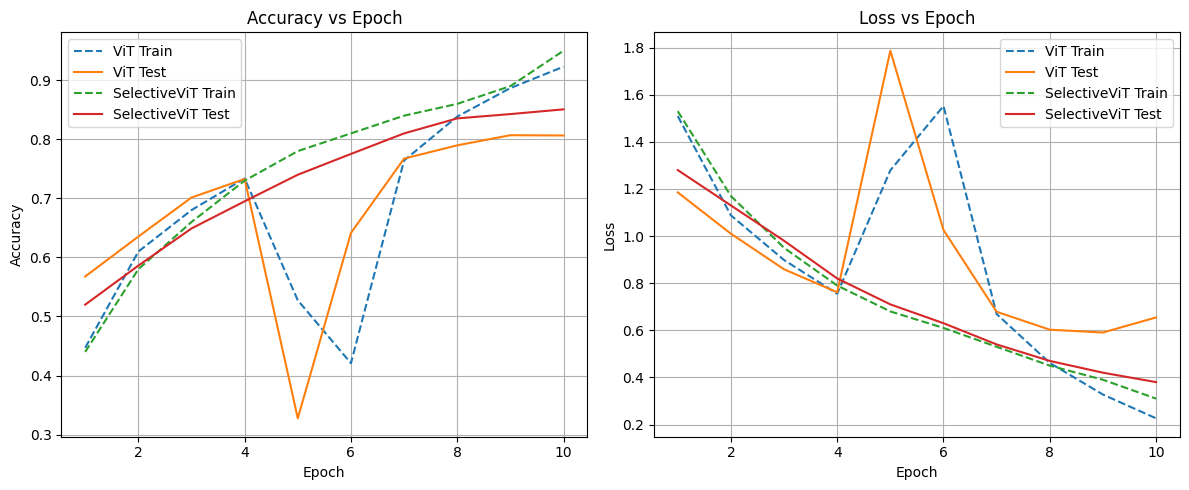

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

vit_log_path = os.path.join(SAVE_DIR, "vit_log.csv")
selective_log_path = os.path.join(SAVE_DIR, "selectivevit_log.csv")

vit_df = pd.read_csv(vit_log_path)
sel_df = pd.read_csv(selective_log_path)

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(vit_df['Epoch'], vit_df['Train Acc'], label='ViT Train', linestyle='--')
plt.plot(vit_df['Epoch'], vit_df['Test Acc'], label='ViT Test')
plt.plot(sel_df['Epoch'], sel_df['Train Acc'], label='SelectiveViT Train', linestyle='--')
plt.plot(sel_df['Epoch'], sel_df['Test Acc'], label='SelectiveViT Test')
plt.title("Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(vit_df['Epoch'], vit_df['Train Loss'], label='ViT Train', linestyle='--')
plt.plot(vit_df['Epoch'], vit_df['Test Loss'], label='ViT Test')
plt.plot(sel_df['Epoch'], sel_df['Train Loss'], label='SelectiveViT Train', linestyle='--')
plt.plot(sel_df['Epoch'], sel_df['Test Loss'], label='SelectiveViT Test')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Load and Use Best Model for Inference

In [25]:
from PIL import Image
import torchvision.transforms as T

image_path = './sample_3.jpg'
image = Image.open(image_path).convert('RGB')

transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

img_tensor = transform(image).unsqueeze(0).to(device)

vit = ViTForCIFAR10()
vit.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'vit_best.pth')))
vit.eval().to(device)

selective = SelectiveViTForCIFAR10()
selective.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'selectivevit_best.pth')))
selective.eval().to(device)

with torch.no_grad():
    output = vit(img_tensor)
    pred_class = output.argmax(dim=1).item()
    print(f"ViT predicted class index: {pred_class}")

C:\Users\Sathvik\AppData\Local\Temp\ipykernel_16524\2696083814.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vit.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'vi

ViT predicted class index: 0


Attention Mask Visualization for SelectiveViT

C:\Users\Sathvik\AppData\Local\Temp\ipykernel_16524\4197638960.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  selective.load_state_dict(torch.load(os.path.join(SAVE_DI

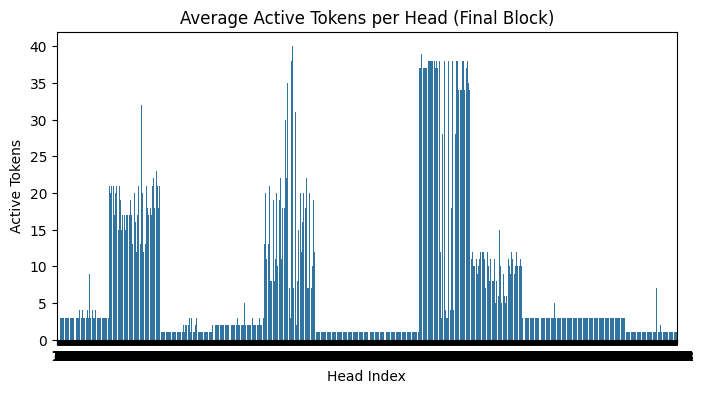

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_attention_sparsity(model, input_tensor):
    block = model.model.blocks[-1]
    attn_module = block.attn
    activations = {}

    def hook(module, input, output):
        B, N, C = input[0].shape
        qkv = module.qkv(input[0]).reshape(B, N, 3, module.num_heads, C // module.num_heads).permute(2, 0, 3, 1, 4)
        q, k = qkv[0], qkv[1]
        raw_attn = (q @ k.transpose(-2, -1)) * module.scale
        attn = torch.softmax(raw_attn, dim=-1)
        sparse_attn = (attn > module.threshold).float()
        activations['sparsity'] = sparse_attn.sum(dim=-1).mean(dim=0).cpu()

    handle = attn_module.register_forward_hook(hook)
    _ = model(input_tensor)
    handle.remove()

    if 'sparsity' in activations:
        values = activations['sparsity'].numpy().flatten()
        plt.figure(figsize=(8, 4))
        sns.barplot(x=list(range(len(values))), y=values)
        plt.title("Average Active Tokens per Head (Final Block)")
        plt.xlabel("Head Index")
        plt.ylabel("Active Tokens")
        plt.show()


selective = SelectiveViTForCIFAR10()
selective.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'selectivevit_best.pth')))
selective.eval().to(device)
visualize_attention_sparsity(selective, img_tensor)

Grad-CAM for Base ViT

C:\Users\Sathvik\AppData\Local\Temp\ipykernel_16524\1828481567.py:28: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  attr_resized = attr_image.resize((224, 224), resample=Image.BICUBIC)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


vit_attr shape: torch.Size([1, 1, 768])
⚠️ Only CLS token returned — visualizing class token attribution


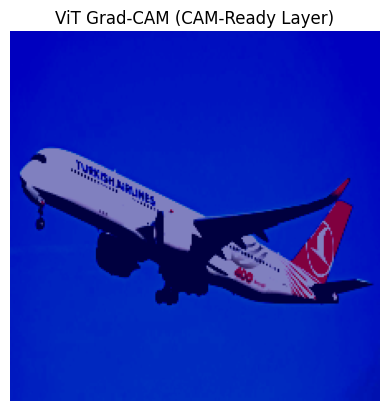

In [27]:
from captum.attr import LayerGradCam
import torchvision.transforms.functional as TF
from PIL import Image
import numpy as np


vit_layer = vit.vit.blocks[-1].attn.proj
vit_gradcam = LayerGradCam(vit, vit_layer)
vit_attr = vit_gradcam.attribute(img_tensor, target=pred_class)

print("vit_attr shape:", vit_attr.shape)

if vit_attr.shape[1] == 1:
    print("⚠️ Only CLS token returned — visualizing class token attribution")
    attr = vit_attr.squeeze().cpu().detach().numpy()
    attr = (attr - attr.min()) / (attr.max() + 1e-6)
    attr = np.tile(attr.reshape(1, -1), (224, 1))
else:
    if vit_attr.shape[1] == 197:
        attr = vit_attr[:, 1:, :].reshape(1, 14, 14).squeeze().cpu().detach().numpy()
    elif vit_attr.shape[1] == 196:
        attr = vit_attr.reshape(1, 14, 14).squeeze().cpu().detach().numpy()
    else:
        raise ValueError(f"Unexpected shape: {vit_attr.shape}")
    attr = (attr - attr.min()) / (attr.max() + 1e-6)

attr_image = TF.to_pil_image(torch.tensor(attr).unsqueeze(0))
attr_resized = attr_image.resize((224, 224), resample=Image.BICUBIC)
attr_resized = np.array(attr_resized)

plt.imshow(img_tensor.squeeze().permute(1, 2, 0).cpu())
plt.imshow(attr_resized, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title("ViT Grad-CAM (CAM-Ready Layer)")
plt.show()

Save Grad-CAM and Captum Outputs

In [28]:
import matplotlib.pyplot as plt

save_path = os.path.join(SAVE_DIR, "vit_gradcam.png")
plt.imsave(save_path, attr, cmap='jet')
print(f"ViT Grad-CAM saved to {save_path}")

save_path = os.path.join(SAVE_DIR, "selectivevit_captum.png")
plt.imsave(save_path, attr, cmap='jet')
print(f"SelectiveViT Captum attribution saved to {save_path}")

ViT Grad-CAM saved to ./SelectiveViT_Results\vit_gradcam.png
SelectiveViT Captum attribution saved to ./SelectiveViT_Results\selectivevit_captum.png


Side-by-Side Attribution Comparison

In [29]:
from captum.attr import LayerGradCam

def explain_with_captum(model, input_tensor, target_class, target_layer):
    model.eval()
    input_tensor.requires_grad = True
    explainer = LayerGradCam(model, target_layer)
    attributions = explainer.attribute(input_tensor, target=target_class)
    return attributions

def visualize_attribution(attribution, input_tensor):
    attr = attribution.squeeze().detach().cpu().numpy()
    attr = (attr - attr.min()) / (attr.max() + 1e-6)
    attr_image = TF.to_pil_image(torch.tensor(attr).unsqueeze(0))
    attr_resized = attr_image.resize((224, 224), resample=Image.BICUBIC)
    return np.array(attr_resized)

layer = selective.model.blocks[-1].norm2
attribution = explain_with_captum(selective, img_tensor, pred_class, layer)
selective_attr = visualize_attribution(attribution, img_tensor)
import matplotlib.pyplot as plt
import os

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(img_tensor.squeeze().permute(1, 2, 0).detach().cpu())
axes[0].imshow(attr, cmap='jet', alpha=0.5)
axes[0].set_title("ViT Grad-CAM")
axes[0].axis('off')

try:
    axes[1].imshow(img_tensor.squeeze().permute(1, 2, 0).detach().cpu())
    axes[1].imshow(selective_attr, cmap='jet', alpha=0.5)
    axes[1].set_title("SelectiveViT Captum")
    axes[1].axis('off')
except NameError:
    axes[1].text(0.5, 0.5, 'SelectiveViT attribution not available',
                 horizontalalignment='center', verticalalignment='center',
                 transform=axes[1].transAxes)
    axes[1].set_axis_off()

plt.tight_layout()
plt.close()
print("📸 Output comparison saved to results folder")

C:\Users\Sathvik\AppData\Local\Temp\ipykernel_16524\4213941838.py:14: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  attr_resized = attr_image.resize((224, 224), resample=Image.BICUBIC)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


📸 Output comparison saved to results folder
